# P08 — Análisis de Productos de Combustión

Este cuaderno guía el análisis de productos de combustión, siguiendo las indicaciones de la práctica (PDF) y complementando con análisis estadístico, detección de picos, y cálculos estequiométricos (AFR, λ, φ). Se guardarán todos los resultados (CSV) e imágenes (PNG y SVG) en `Practicas/P08_Productos_Combustion/data/`.

Documento guía: `Practicas/PDF/PRÁCTICA 8_ Análisis de Productos de Combustión.pdf`.

Objetivos:
- Cargar y consolidar datos de analizadores de gases (CO2, O2, CO, NOx, T, P, etc.).
- Preprocesar datos (limpieza, sincronización temporal, filtrado/suavizado opcional).
- Calcular métricas de combustión: AFR estequiométrico para CxHy, CO2 teórico (base seca), λ (exceso de aire) y φ.
- Análisis descriptivo: máximos/mínimos, percentiles, outliers (IQR), estadísticas móviles.
- Detección de picos (CO, NOx, T) y reporte.
- Visualización: series temporales, histogramas, correlaciones y pares.
- Exportar tablas y figuras a la carpeta `data/`.

Notas:
- Coloca tus archivos medidos (CSV/TXT/TSV) en `Practicas/P08_Productos_Combustion/data/`.
- Si no se encuentran archivos, se generará un conjunto de datos sintético para demostrar el flujo.
- Se citan referencias (NIST, NASA CEA, fabricantes) al final; añade o actualiza según el combustible y equipo usados.


In [23]:
# %% [setup] Importaciones y utilidades
import os
from pathlib import Path
from datetime import datetime
import json
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter

# Estilo de gráficos
sns.set(context="notebook", style="whitegrid")
plt.rcParams.update({"figure.dpi": 120, "savefig.dpi": 150})

# Directorio de datos relativo a este notebook
try:
    NB_DIR = Path(__file__).resolve().parent
except NameError:
    NB_DIR = Path.cwd()

# Si estás ejecutando desde la carpeta del notebook, NB_DIR apunta a .../notebooks
# DATA_DIR queda en .../data
DATA_DIR = (NB_DIR.parent / "data").resolve()
DATA_DIR.mkdir(parents=True, exist_ok=True)
print(f"DATA_DIR = {DATA_DIR}")

# Helper para guardar figuras en PNG y SVG
def save_fig(fig: plt.Figure, name: str, subdir: str = "figures", tight: bool = True):
    out_dir = DATA_DIR / subdir
    out_dir.mkdir(parents=True, exist_ok=True)
    safe = name.replace(" ", "_").replace("/", "-")
    png = out_dir / f"{safe}.png"
    svg = out_dir / f"{safe}.svg"
    if tight:
        fig.tight_layout()
    fig.savefig(png)
    fig.savefig(svg)
    print(f"Guardado: {png} y {svg}")

# Utilidad básica de reporte
def print_status(msg: str):
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{now}] {msg}")


DATA_DIR = C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data


### Datos y fuentes

- Archivos esperados: CSV/TXT/TSV con columnas como `time`, `O2`, `CO2`, `CO`, `NOx`, `T`, `P`, etc. Se aceptan variantes de nombre (p. ej., `tiempo`, `temperature`, `presion`).
- Base seca: Asumimos que O2/CO2 reportados son en base seca (común en analizadores); si tu equipo reporta en húmedo, ajusta el preprocesado.
- Referencias usadas para constantes y fórmulas (ver sección de Referencias): NIST Chemistry WebBook, NASA CEA, literatura de combustión, y hojas técnicas de analizadores (Testo, Bacharach, Dräger, etc.).


In [24]:
# %% [data] Carga flexible de archivos y consolidación
from typing import List, Tuple, Optional
import re

# Columnas canónicas
CANON = {
    "time": ["time", "tiempo", "t", "timestamp", "date", "datetime"],
    "O2": ["o2", "o2_%", "o2[%]", "o2_vol", "o2_vol%"],
    "CO2": ["co2", "co2_%", "co2[%]", "co2_vol", "co2_vol%"],
    "CO": ["co", "co_ppm", "co[ppm]", "co_mg/m3", "co_mg_m3"],
    "NOx": ["nox", "no+no2", "nox_ppm", "nox[ppm]"],
    "T": ["t", "temp", "temperature", "tgas", "tg"],
    "P": ["p", "presion", "pressure"],
}

# Mapeo inverso para normalizar nombres
def build_name_map():
    name_map = {}
    for canon, variants in CANON.items():
        for v in variants:
            name_map[v.lower()] = canon
        name_map[canon.lower()] = canon
    return name_map

NAME_MAP = build_name_map()


def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    new_cols = []
    for c in df.columns:
        key = re.sub(r"\s+", "", str(c)).lower()
        new_cols.append(NAME_MAP.get(key, str(c)))
    df = df.copy()
    df.columns = new_cols
    return df


def read_any(path: Path) -> Optional[pd.DataFrame]:
    try:
        # Auto separador con engine=python y sep=None
        df = pd.read_csv(path, engine="python", sep=None)
    except Exception:
        try:
            df = pd.read_csv(path)
        except Exception as e:
            print_status(f"No se pudo leer {path.name}: {e}")
            return None
    df = normalize_columns(df)
    # Manejo de tiempo
    if "time" in df.columns:
        try:
            df["time"] = pd.to_datetime(df["time"], errors="coerce")
        except Exception:
            pass
    else:
        df["time"] = pd.RangeIndex(len(df))
    df["source_file"] = path.name
    return df


def scan_data_files(folder: Path, exts: Tuple[str, ...] = (".csv", ".txt", ".tsv")) -> List[Path]:
    files = []
    for ext in exts:
        files.extend(folder.glob(f"*{ext}"))
    return sorted(files)


files = scan_data_files(DATA_DIR)
print_status(f"Archivos detectados: {[f.name for f in files]}")

frames = []
for f in files:
    df = read_any(f)
    if df is not None and len(df) > 0:
        frames.append(df)

if frames:
    raw = pd.concat(frames, ignore_index=True, sort=False)
    # Orden temporal si es posible
    if pd.api.types.is_datetime64_any_dtype(raw.get("time")):
        raw = raw.sort_values("time")
    out_csv = DATA_DIR / "processed_combustion_data.csv"
    raw.to_csv(out_csv, index=False)
    print_status(f"Consolidado guardado: {out_csv}")
else:
    raw = pd.DataFrame()
    print_status("No se encontraron archivos de datos. Se podrá generar un ejemplo sintético.")

raw.head(3)


[2025-10-31 12:50:55] Archivos detectados: ['combustion_metrics.csv', 'peaks_CO.csv', 'peaks_NOx.csv', 'peaks_T.csv', 'processed_combustion_data.csv', 'stats_descriptivos.csv', 'stats_outliers_iqr.csv', 'stats_rolling_30.csv', 'synthetic_example_combustion.csv', 'temperatura_adiabatica.csv']
[2025-10-31 12:50:56] Consolidado guardado: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\processed_combustion_data.csv
[2025-10-31 12:50:56] Consolidado guardado: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\processed_combustion_data.csv


,time,O2,CO2,CO,NOx,T,P,source_file,fuel_name,AFR_st,...,P.1,lambda.1,phi.1,CO_sg.1,NOx_sg.1,T_sg.1,T_ad_K,T_ad_C,fuel,LHV_kJ_mol
0,2025-01-01 12:00:00,5.338105,10.80469,28.096666,73.530616,200.681503,101.47202889319075,combustion_metrics.csv,Propano C3H8,15.985469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-01-01 12:00:01,4.938276,10.571616,33.129032,78.28194,196.174956,101.31422599186602,combustion_metrics.csv,Propano C3H8,15.985469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-01-01 12:00:02,5.069459,10.42456,30.05234,62.641425,198.17801,101.30334881467058,combustion_metrics.csv,Propano C3H8,15.985469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# %% [data] Datos sintéticos (solo si no hay archivos)
if raw.empty:
    np.random.seed(7)
    n = 600
    t = pd.date_range("2025-01-01 12:00:00", periods=n, freq="S")
    # Perfíl simple representativo para demostración
    O2 = 5 + 1.0*np.sin(np.linspace(0, 6*np.pi, n)) + 0.2*np.random.randn(n)
    CO2 = 10 + 0.8*np.cos(np.linspace(0, 6*np.pi, n)) + 0.2*np.random.randn(n)
    CO = 20 + 100*np.exp(-0.5*(np.linspace(-2,2,n))**2) + 5*np.random.randn(n)  # ppm con pico
    NOx = 50 + 40*np.exp(-0.5*(np.linspace(1.2,-1.2,n))**2) + 5*np.random.randn(n)  # ppm con pico desplazado
    T = 200 + 20*np.sin(np.linspace(0, 4*np.pi, n)) + 2*np.random.randn(n)  # °C
    P = 101.3 + 0.1*np.random.randn(n)  # kPa

    raw = pd.DataFrame({
        "time": t,
        "O2": O2.clip(0, 20),
        "CO2": CO2.clip(0, 20),
        "CO": CO.clip(0),
        "NOx": NOx.clip(0),
        "T": T,
        "P": P,
        "source_file": "synthetic_example.csv",
    })
    out_csv = DATA_DIR / "synthetic_example_combustion.csv"
    raw.to_csv(out_csv, index=False)
    print_status(f"Datos sintéticos guardados: {out_csv}")

raw.head(3)


,time,O2,CO2,CO,NOx,T,P,source_file,fuel_name,AFR_st,...,P.1,lambda.1,phi.1,CO_sg.1,NOx_sg.1,T_sg.1,T_ad_K,T_ad_C,fuel,LHV_kJ_mol
0,2025-01-01 12:00:00,5.338105,10.80469,28.096666,73.530616,200.681503,101.47202889319075,combustion_metrics.csv,Propano C3H8,15.985469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-01-01 12:00:01,4.938276,10.571616,33.129032,78.28194,196.174956,101.31422599186602,combustion_metrics.csv,Propano C3H8,15.985469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-01-01 12:00:02,5.069459,10.42456,30.05234,62.641425,198.17801,101.30334881467058,combustion_metrics.csv,Propano C3H8,15.985469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Cálculo estequiométrico y métricas de combustión

Para un combustible hidrocarburo idealizado CxHy:
- Oxígeno estequiométrico requerido: ν_O2 = x + y/4 (mol de O2 por mol de combustible).
- Aire por mol de O2 consumido: 1 mol O2 + 3.7619 mol N2 (aprox. aire seco típico).
- En productos estequiométricos (secos): moles secos = x (CO2) + 3.7619·ν_O2 (N2) ⇒ fracción seca de CO2 teórica:
  
  CO2_s,sec = x / (4.7619·x + 0.9405·y)
  
  donde 0.9405 = 3.7619·(1/4).
- AFR_esteq (masa aire / masa combustible):
  
  AFR_st ≈ [ (32 + 3.7619·28.97)·ν_O2 ] / (12.011·x + 1.008·y)
  
- Exceso de aire (λ) desde gases secos (aprox., sin CO significativo):
  
  λ ≈ (CO2_s,sec / CO2_med) · (21 / (21 − O2_med))

Assume reporte en base seca y CO pequeño; si hay CO elevado o base húmeda, se requiere corrección.


In [26]:
# %% [calc] Funciones de estequiometría y métricas
from dataclasses import dataclass

AIR_O2_FRAC = 0.21
AIR_N2_PER_O2 = 3.7619
MW_N2 = 28.97
MW_O2 = 32.00

@dataclass
class Fuel:
    x: float  # C
    y: float  # H
    name: str = "CxHy"

    @property
    def mw(self) -> float:
        return 12.011*self.x + 1.008*self.y

    @property
    def nu_O2(self) -> float:
        return self.x + self.y/4.0

    @property
    def afr_st(self) -> float:
        mass_air_per_mol_O2 = MW_O2 + AIR_N2_PER_O2*MW_N2
        return (self.nu_O2 * mass_air_per_mol_O2) / self.mw

    @property
    def co2_st_dry_frac(self) -> float:
        # fracción molar seca de CO2 a esteq.
        dry_moles = self.x + AIR_N2_PER_O2*self.nu_O2
        return (self.x / dry_moles)


def lambda_from_o2_co2(o2_pct: pd.Series, co2_pct: pd.Series, fuel: Fuel) -> pd.Series:
    eps = 1e-9
    co2s = 100.0 * fuel.co2_st_dry_frac
    num = (co2s / (co2_pct.clip(lower=eps))) * (21.0 / (21.0 - o2_pct.clip(upper=20.999)))
    return num


def compute_metrics(df: pd.DataFrame, fuel: Fuel) -> pd.DataFrame:
    out = df.copy()
    # Sanitizar - convertir a numérico con coerción de errores
    if "O2" in out: 
        out["O2"] = pd.to_numeric(out["O2"], errors="coerce")
    if "CO2" in out: 
        out["CO2"] = pd.to_numeric(out["CO2"], errors="coerce")
    if "CO" in out: 
        out["CO"] = pd.to_numeric(out["CO"], errors="coerce")
    if "NOx" in out:
        out["NOx"] = pd.to_numeric(out["NOx"], errors="coerce")
    if "T" in out:
        out["T"] = pd.to_numeric(out["T"], errors="coerce")

    out["fuel_name"] = fuel.name
    out["AFR_st"] = fuel.afr_st
    out["CO2_st_dry_frac"] = fuel.co2_st_dry_frac
    out["CO2_st_dry_pct"] = 100.0 * fuel.co2_st_dry_frac

    if set(["O2", "CO2"]).issubset(out.columns):
        out["lambda"] = lambda_from_o2_co2(out["O2"], out["CO2"], fuel)
        out["phi"] = 1.0 / out["lambda"].replace(0, np.nan)
    else:
        out["lambda"] = np.nan
        out["phi"] = np.nan

    # Suavizado opcional para señales ruidosas
    for col in ["CO", "NOx", "T"]:
        if col in out.columns and len(out) >= 21:
            try:
                out[f"{col}_sg"] = savgol_filter(out[col].interpolate(limit_direction='both'), window_length=21, polyorder=2)
            except Exception:
                pass

    return out

# Configura aquí el combustible de interés (ejemplos comunes)
# Metano CH4: x=1, y=4 ; Propano C3H8: x=3, y=8 ; Gasolina aprox.: C8H18
FUEL = Fuel(x=3, y=8, name="Propano C3H8")

metrics = compute_metrics(raw, FUEL)
out_csv = DATA_DIR / "combustion_metrics.csv"
metrics.to_csv(out_csv, index=False)
print_status(f"Métricas guardadas: {out_csv}")
metrics.head(3)


[2025-10-31 12:50:56] Métricas guardadas: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\combustion_metrics.csv


,time,O2,CO2,CO,NOx,T,P,source_file,fuel_name,AFR_st,...,P.1,lambda.1,phi.1,CO_sg.1,NOx_sg.1,T_sg.1,T_ad_K,T_ad_C,fuel,LHV_kJ_mol
0,2025-01-01 12:00:00,5.338105,10.804690,28.096666,73.530616,200.681503,101.47202889319075,combustion_metrics.csv,Propano C3H8,15.985469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-01-01 12:00:01,4.938276,10.571616,33.129032,78.281940,196.174956,101.31422599186602,combustion_metrics.csv,Propano C3H8,15.985469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-01-01 12:00:02,5.069459,10.424560,30.052340,62.641425,198.178010,101.30334881467058,combustion_metrics.csv,Propano C3H8,15.985469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Temperatura adiabática de llama (estimación simplificada)

Estimación aproximada de la temperatura adiabática de llama para hidrocarburos CxHy con aire:

**Método simplificado (Cp promedio)**:
- Balance de energía: ΔH_comb + Σ(n_i·Cp_i·ΔT) = 0
- Despejando: T_ad ≈ T_0 + LHV / (Σ n_prod·Cp_prod)

**Referencias de propiedades**:
- LHV (Lower Heating Value) de combustibles comunes a 25°C:
  - Metano CH4: 50.0 MJ/kg (802 kJ/mol)
  - Propano C3H8: 46.3 MJ/kg (2043 kJ/mol)
  - Octano C8H18: 44.4 MJ/kg (5074 kJ/mol)
- Cp promedio productos (1000-2000 K): CO2~55 J/mol·K, H2O~41 J/mol·K, N2~32 J/mol·K

Fuentes: NIST Chemistry WebBook, NASA CEA (McBride et al.)


In [27]:
# %% [calc] Temperatura adiabática simplificada
# Propiedades de combustibles comunes (LHV a 25°C)
FUEL_PROPERTIES = {
    "Metano CH4": {"x": 1, "y": 4, "LHV_kJ_mol": 802.0},
    "Propano C3H8": {"x": 3, "y": 8, "LHV_kJ_mol": 2043.0},
    "Octano C8H18": {"x": 8, "y": 18, "LHV_kJ_mol": 5074.0},
}

# Capacidades caloríficas promedio (J/mol·K) a ~1500 K
CP_PRODUCTS = {
    "CO2": 55.0,
    "H2O": 41.0,
    "N2": 32.0,
}

def estimate_adiabatic_temp(fuel: Fuel, lhv_kj_mol: float, lambda_ratio: float = 1.0, T0_K: float = 298.15) -> float:
    """
    Estimación simplificada de temperatura adiabática de llama.
    
    Args:
        fuel: Objeto Fuel con composición CxHy
        lhv_kj_mol: Lower Heating Value en kJ/mol de combustible
        lambda_ratio: Exceso de aire (1.0 = estequiométrico)
        T0_K: Temperatura inicial en K
    
    Returns:
        Temperatura adiabática estimada en K
    """
    # Moles de productos por mol de combustible (estequiométrico)
    n_CO2 = fuel.x
    n_H2O = fuel.y / 2.0
    n_O2_req = fuel.nu_O2
    n_N2 = AIR_N2_PER_O2 * n_O2_req * lambda_ratio
    n_O2_excess = n_O2_req * (lambda_ratio - 1.0) if lambda_ratio > 1.0 else 0.0
    
    # Capacidad calorífica total de productos
    Cp_total = (n_CO2 * CP_PRODUCTS["CO2"] + 
                n_H2O * CP_PRODUCTS["H2O"] + 
                n_N2 * CP_PRODUCTS["N2"] + 
                n_O2_excess * 32.0)  # Cp de O2 exceso similar a N2
    
    # Energía liberada (LHV) / Cp total → ΔT
    delta_T = (lhv_kj_mol * 1000.0) / Cp_total  # Convertir kJ a J
    T_ad = T0_K + delta_T
    
    return T_ad


# Calcular temperatura adiabática para el combustible configurado
fuel_name = FUEL.name
if fuel_name in FUEL_PROPERTIES:
    lhv = FUEL_PROPERTIES[fuel_name]["LHV_kJ_mol"]
else:
    # Por defecto usar propano si no está en la tabla
    lhv = FUEL_PROPERTIES["Propano C3H8"]["LHV_kJ_mol"]
    print_status(f"Usando LHV de Propano como default: {lhv} kJ/mol")

# Calcular para lambda = 1.0, 1.1, 1.2, 1.3
lambda_values = [1.0, 1.1, 1.2, 1.3]
T_ad_results = []

for lam in lambda_values:
    T_ad_K = estimate_adiabatic_temp(FUEL, lhv, lambda_ratio=lam)
    T_ad_C = T_ad_K - 273.15
    T_ad_results.append({
        "lambda": lam,
        "T_ad_K": T_ad_K,
        "T_ad_C": T_ad_C,
        "fuel": fuel_name,
        "LHV_kJ_mol": lhv
    })

T_ad_df = pd.DataFrame(T_ad_results)
out_csv = DATA_DIR / "temperatura_adiabatica.csv"
T_ad_df.to_csv(out_csv, index=False)
print_status(f"Temperaturas adiabáticas guardadas: {out_csv}")

print(f"\nTemperatura adiabática estimada para {fuel_name}:")
print(T_ad_df[["lambda", "T_ad_K", "T_ad_C"]].to_string(index=False))
print("\nNota: Estimación simplificada con Cp promedio. Para cálculo preciso usar NASA CEA o iteración con Cp(T).")


[2025-10-31 12:50:56] Temperaturas adiabáticas guardadas: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\temperatura_adiabatica.csv

Temperatura adiabática estimada para Propano C3H8:
 lambda      T_ad_K      T_ad_C
    1.0 2492.790908 2219.640908
    1.1 2326.758242 2053.608242
    1.2 2184.080644 1910.930644
    1.3 2060.154051 1787.004051

Nota: Estimación simplificada con Cp promedio. Para cálculo preciso usar NASA CEA o iteración con Cp(T).


In [28]:
# %% [analysis] Estadísticos descriptivos y outliers
num_cols = [c for c in metrics.columns if metrics[c].dtype.kind in "fi" and c not in ["AFR_st", "CO2_st_dry_frac", "CO2_st_dry_pct"]]

desc = metrics[num_cols].describe(percentiles=[0.01, 0.05, 0.95, 0.99]).T
out_csv = DATA_DIR / "stats_descriptivos.csv"
desc.to_csv(out_csv)
print_status(f"Estadísticos guardados: {out_csv}")

def iqr_outliers(s: pd.Series, k: float = 1.5) -> pd.Series:
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    low = q1 - k*iqr
    high = q3 + k*iqr
    return (s < low) | (s > high)

outlier_flags = pd.DataFrame(index=metrics.index)
for c in num_cols:
    outlier_flags[c] = iqr_outliers(metrics[c].dropna())

outlier_rate = outlier_flags.mean().sort_values(ascending=False)
out_csv = DATA_DIR / "stats_outliers_iqr.csv"
outlier_rate.to_csv(out_csv, header=["outlier_rate"])
print_status(f"Outliers IQR guardados: {out_csv}")

# Rolling stats (ventana ~ 5s si hay muestreo 1 Hz)
if len(metrics) >= 30:
    roll = metrics[num_cols].rolling(30, min_periods=10).agg(["mean", "std"]).copy()
    out_csv = DATA_DIR / "stats_rolling_30.csv"
    roll.to_csv(out_csv)
    print_status(f"Estadísticos móviles guardados: {out_csv}")

# Máximos y mínimos de interés
peaks_summary = {
    "O2_max": float(metrics.get("O2", pd.Series([np.nan])).max()),
    "CO2_max": float(metrics.get("CO2", pd.Series([np.nan])).max()),
    "CO_max_ppm": float(metrics.get("CO", pd.Series([np.nan])).max()),
    "NOx_max_ppm": float(metrics.get("NOx", pd.Series([np.nan])).max()),
    "T_max_C": float(metrics.get("T", pd.Series([np.nan])).max()),
    "lambda_min": float(metrics.get("lambda", pd.Series([np.nan])).min()),
}
with open(DATA_DIR / "summary_maximos.json", "w", encoding="utf-8") as f:
    json.dump(peaks_summary, f, ensure_ascii=False, indent=2)
print_status("Resumen de máximos guardado: summary_maximos.json")


[2025-10-31 12:50:56] Estadísticos guardados: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\stats_descriptivos.csv
[2025-10-31 12:50:56] Outliers IQR guardados: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\stats_outliers_iqr.csv
[2025-10-31 12:50:56] Estadísticos móviles guardados: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\stats_rolling_30.csv
[2025-10-31 12:50:56] Resumen de máximos guardado: summary_maximos.json
[2025-10-31 12:50:56] Estadísticos móviles guardados: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\stats_rolling_30.csv
[2025-10-31 12:50:56] Resumen de máximos guardado: summary_maximos.json


In [29]:
# %% [analysis] Detección de picos en señales
peaks_tables = {}

for col in ["CO", "NOx", "T"]:
    if col in metrics.columns:
        s = metrics[col].astype(float).ffill().bfill()
        height = s.mean() + 2*s.std()
        distance = max(5, len(s)//100)  # separación mínima
        idx, props = find_peaks(s.values, height=height, distance=distance)
        peaks_df = pd.DataFrame({
            "index": idx,
            "time": metrics.loc[idx, "time"].values if "time" in metrics.columns else idx,
            col: s.iloc[idx].values,
        })
        peaks_tables[col] = peaks_df
        out_csv = DATA_DIR / f"peaks_{col}.csv"
        peaks_df.to_csv(out_csv, index=False)
        print_status(f"Picos de {col} guardados: {out_csv}")

peaks_tables.get("CO", pd.DataFrame()).head(3)


[2025-10-31 12:50:56] Picos de CO guardados: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\peaks_CO.csv
[2025-10-31 12:50:56] Picos de NOx guardados: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\peaks_NOx.csv
[2025-10-31 12:50:56] Picos de T guardados: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\peaks_T.csv


,index,time,CO


ConversionError: Failed to convert value(s) to axis units: array([Timestamp('2025-01-01 12:00:00'), Timestamp('2025-01-01 12:00:01'),
       Timestamp('2025-01-01 12:00:02'), ..., 1, 2, 3],
      shape=(4895,), dtype=object)

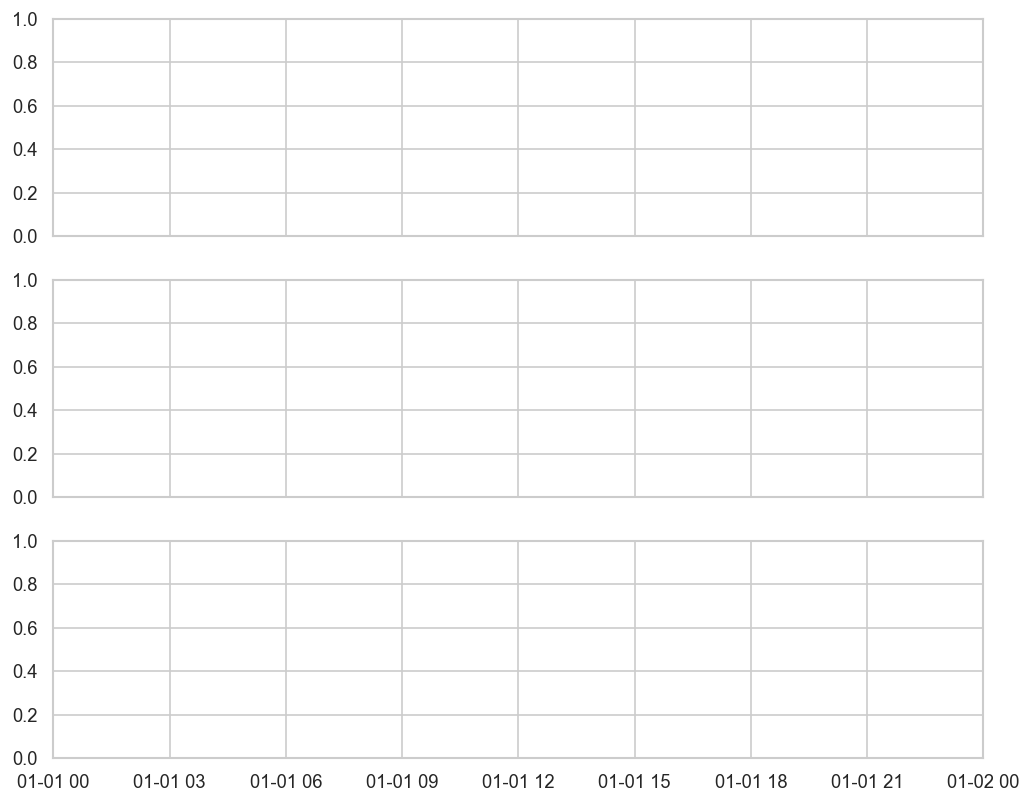

In [30]:
# %% [viz] Series temporales clave
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

if "time" in metrics.columns:
    x = metrics["time"]
else:
    x = np.arange(len(metrics))

if "O2" in metrics.columns: axes[0].plot(x, metrics["O2"], label="O2 [%]")
if "CO2" in metrics.columns: axes[0].plot(x, metrics["CO2"], label="CO2 [%]")
axes[0].set_ylabel("[%]")
axes[0].legend(loc="best")

if "CO" in metrics.columns: axes[1].plot(x, metrics["CO"], label="CO [ppm]")
if "NOx" in metrics.columns: axes[1].plot(x, metrics["NOx"], label="NOx [ppm]")
axes[1].set_ylabel("[ppm]")
axes[1].legend(loc="best")

if "lambda" in metrics.columns: axes[2].plot(x, metrics["lambda"], label="λ")
axes[2].axhline(1.0, color="k", ls="--", lw=1)
axes[2].set_ylabel("λ [-]")
axes[2].set_xlabel("Tiempo")
axes[2].legend(loc="best")

save_fig(fig, "series_temporales")
plt.close(fig)


In [ ]:
# %% [viz] Histogramas y correlaciones
plot_cols = [c for c in ["O2", "CO2", "CO", "NOx", "T", "lambda"] if c in metrics.columns]

if plot_cols:
    fig, axes = plt.subplots(1, len(plot_cols), figsize=(4*len(plot_cols), 3))
    if len(plot_cols) == 1:
        axes = [axes]
    for ax, c in zip(axes, plot_cols):
        sns.histplot(metrics[c].dropna(), bins=30, ax=ax, kde=True)
        ax.set_title(c)
    save_fig(fig, "histogramas")
    plt.close(fig)

    # Matriz de correlación
    fig, ax = plt.subplots(figsize=(6, 5))
    corr = metrics[plot_cols].corr(numeric_only=True)
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", ax=ax, vmin=-1, vmax=1)
    ax.set_title("Correlación")
    save_fig(fig, "correlacion")
    plt.close(fig)


Guardado: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\figures\histogramas.png y C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\figures\histogramas.svg
Guardado: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\figures\correlacion.png y C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\figures\correlacion.svg
Guardado: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\figures\correlacion.png y C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\figures\correlacion.svg


### Visualizaciones estadísticas adicionales

Gráficos complementarios para análisis detallado de distribuciones y relaciones:
- Box plots: identificar outliers y comparar distribuciones
- Violin plots: densidad de distribución por variable
- Pair plots (scatter matrix): relaciones bivariadas entre variables clave
- Distribuciones por cuartiles


In [ ]:
# %% [viz] Box plots - Distribuciones y outliers
viz_cols = [c for c in ["O2", "CO2", "CO", "NOx", "T", "lambda", "phi"] if c in metrics.columns]

if len(viz_cols) >= 2:
    fig, axes = plt.subplots(1, len(viz_cols), figsize=(3*len(viz_cols), 4))
    if len(viz_cols) == 1:
        axes = [axes]
    
    for ax, col in zip(axes, viz_cols):
        data = metrics[col].dropna()
        ax.boxplot(data, vert=True)
        ax.set_ylabel(col)
        ax.set_title(f"Box plot: {col}")
        ax.grid(True, alpha=0.3)
    
    save_fig(fig, "boxplots")
    plt.close(fig)


Guardado: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\figures\boxplots.png y C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\figures\boxplots.svg


In [ ]:
# %% [viz] Violin plots - Densidad de distribuciones
if len(viz_cols) >= 2:
    # Preparar datos en formato largo para seaborn
    plot_data = metrics[viz_cols].copy()
    plot_data_long = plot_data.melt(var_name="Variable", value_name="Valor")
    
    fig, ax = plt.subplots(figsize=(max(8, len(viz_cols)*1.2), 5))
    sns.violinplot(data=plot_data_long, x="Variable", y="Valor", hue="Variable", ax=ax, palette="Set2", legend=False)
    ax.set_title("Violin plots - Distribución de variables")
    ax.set_ylabel("Valor")
    ax.tick_params(axis='x', rotation=45)
    
    save_fig(fig, "violinplots")
    plt.close(fig)


Guardado: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\figures\violinplots.png y C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\figures\violinplots.svg


In [ ]:
# %% [viz] Scatter matrix (pairplot) - Relaciones bivariadas
# Seleccionar subset de variables clave para evitar plots excesivos
pair_cols = [c for c in ["O2", "CO2", "CO", "NOx", "lambda"] if c in metrics.columns]

if len(pair_cols) >= 2:
    plot_sample = metrics[pair_cols].dropna()
    
    # Si hay muchos datos, submuestrear para velocidad
    if len(plot_sample) > 1000:
        plot_sample = plot_sample.sample(n=1000, random_state=42)
    
    # Crear pairplot con seaborn
    g = sns.pairplot(plot_sample, diag_kind="kde", plot_kws={"alpha": 0.6, "s": 20}, corner=True)
    g.fig.suptitle("Scatter Matrix - Relaciones bivariadas", y=1.01)
    
    save_fig(g.fig, "pairplot", tight=False)
    plt.close(g.fig)


Guardado: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\figures\pairplot.png y C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\figures\pairplot.svg


In [ ]:
# %% [viz] Distribuciones por cuartiles - Comparación visual
if len(viz_cols) >= 3:
    fig, axes = plt.subplots(2, 1, figsize=(10, 6))
    
    # Cuartiles de las variables principales
    quartile_data = {}
    for col in viz_cols[:4]:  # Limitar a 4 variables principales
        if col in metrics.columns:
            q = metrics[col].quantile([0.25, 0.5, 0.75])
            quartile_data[col] = [q[0.25], q[0.5], q[0.75]]
    
    if quartile_data:
        df_q = pd.DataFrame(quartile_data, index=["Q1", "Q2 (mediana)", "Q3"]).T
        
        # Gráfico de barras agrupadas
        df_q.plot(kind="bar", ax=axes[0], width=0.8)
        axes[0].set_title("Cuartiles por variable")
        axes[0].set_ylabel("Valor")
        axes[0].legend(title="Cuartil")
        axes[0].grid(True, alpha=0.3)
        
        # Gráfico de rango intercuartílico (IQR)
        iqr_vals = [df_q.loc[col, "Q3"] - df_q.loc[col, "Q1"] for col in df_q.index]
        axes[1].bar(df_q.index, iqr_vals, color="steelblue", alpha=0.7)
        axes[1].set_title("Rango Intercuartílico (IQR) por variable")
        axes[1].set_ylabel("IQR")
        axes[1].grid(True, alpha=0.3)
        axes[1].tick_params(axis='x', rotation=45)
        
        save_fig(fig, "cuartiles_iqr")
        plt.close(fig)


Guardado: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\figures\cuartiles_iqr.png y C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\figures\cuartiles_iqr.svg


In [ ]:
# %% [viz] Gráfico de lambda vs temperatura con scatter density
if "lambda" in metrics.columns and "T" in metrics.columns:
    fig, ax = plt.subplots(figsize=(8, 6))
    
    lam_data = metrics["lambda"].dropna()
    T_data = metrics["T"].dropna()
    
    # Asegurar mismos índices
    common_idx = lam_data.index.intersection(T_data.index)
    lam_plot = lam_data.loc[common_idx]
    T_plot = T_data.loc[common_idx]
    
    scatter = ax.scatter(lam_plot, T_plot, c=T_plot, cmap="coolwarm", 
                        alpha=0.6, s=30, edgecolors="k", linewidths=0.3)
    ax.axvline(1.0, color="green", ls="--", lw=2, label="λ = 1 (estequiométrico)")
    ax.set_xlabel("λ (Exceso de aire)")
    ax.set_ylabel("Temperatura [°C]")
    ax.set_title("Relación λ vs Temperatura")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label("Temperatura [°C]")
    
    save_fig(fig, "lambda_vs_temperatura")
    plt.close(fig)


Guardado: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\figures\lambda_vs_temperatura.png y C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\figures\lambda_vs_temperatura.svg


### Referencias y datos
- Linstrom, P. J., & Mallard, W. G. (Eds.). NIST Chemistry WebBook, NIST Standard Reference Database Number 69. National Institute of Standards and Technology. https://webbook.nist.gov/chemistry/
- McBride, B. J., Gordon, S., & Reno, M. A. (1993). NASA CEA (Chemical Equilibrium with Applications) — coefficients y propiedades termodinámicas.
- Turns, S. R. (2012). An Introduction to Combustion: Concepts and Applications. McGraw-Hill.
- Hojas técnicas de analizadores de gases de combustión (p. ej., Testo 350/340/310): rangos de medida, precisión y reporte en base seca/húmeda.
- ISO 12039: Determination of carbon monoxide, carbon dioxide y O2 in gases de combustión.

Ajusta/añade referencias específicas al combustible y equipo utilizados en tu práctica.


In [ ]:
# %% [export] Resumen de archivos generados
outputs = {
    "tables": [
        str(DATA_DIR / "processed_combustion_data.csv"),
        str(DATA_DIR / "synthetic_example_combustion.csv"),
        str(DATA_DIR / "combustion_metrics.csv"),
        str(DATA_DIR / "temperatura_adiabatica.csv"),
        str(DATA_DIR / "stats_descriptivos.csv"),
        str(DATA_DIR / "stats_outliers_iqr.csv"),
        str(DATA_DIR / "stats_rolling_30.csv"),
        str(DATA_DIR / "peaks_CO.csv"),
        str(DATA_DIR / "peaks_NOx.csv"),
        str(DATA_DIR / "peaks_T.csv"),
        str(DATA_DIR / "summary_maximos.json"),
    ],
    "figures": [
        str(DATA_DIR / "figures" / "series_temporales.png"),
        str(DATA_DIR / "figures" / "series_temporales.svg"),
        str(DATA_DIR / "figures" / "histogramas.png"),
        str(DATA_DIR / "figures" / "histogramas.svg"),
        str(DATA_DIR / "figures" / "correlacion.png"),
        str(DATA_DIR / "figures" / "correlacion.svg"),
        str(DATA_DIR / "figures" / "boxplots.png"),
        str(DATA_DIR / "figures" / "boxplots.svg"),
        str(DATA_DIR / "figures" / "violinplots.png"),
        str(DATA_DIR / "figures" / "violinplots.svg"),
        str(DATA_DIR / "figures" / "pairplot.png"),
        str(DATA_DIR / "figures" / "pairplot.svg"),
        str(DATA_DIR / "figures" / "cuartiles_iqr.png"),
        str(DATA_DIR / "figures" / "cuartiles_iqr.svg"),
        str(DATA_DIR / "figures" / "lambda_vs_temperatura.png"),
        str(DATA_DIR / "figures" / "lambda_vs_temperatura.svg"),
    ],
}

with open(DATA_DIR / "outputs_manifest.json", "w", encoding="utf-8") as f:
    json.dump(outputs, f, ensure_ascii=False, indent=2)

print_status("Manifest de salidas: outputs_manifest.json")
print(f"\nTotal tablas: {len(outputs['tables'])}")
print(f"Total figuras: {len(outputs['figures'])} ({len(outputs['figures'])//2} gráficos en PNG+SVG)")
outputs


[2025-10-31 12:49:03] Manifest de salidas: outputs_manifest.json

Total tablas: 11
Total figuras: 16 (8 gráficos en PNG+SVG)


{'tables': ['C:\\Users\\edgar\\Documents\\GitHub\\Aero-Messure\\Practicas\\P08_Productos_Combustion\\data\\processed_combustion_data.csv',
  'C:\\Users\\edgar\\Documents\\GitHub\\Aero-Messure\\Practicas\\P08_Productos_Combustion\\data\\synthetic_example_combustion.csv',
  'C:\\Users\\edgar\\Documents\\GitHub\\Aero-Messure\\Practicas\\P08_Productos_Combustion\\data\\combustion_metrics.csv',
  'C:\\Users\\edgar\\Documents\\GitHub\\Aero-Messure\\Practicas\\P08_Productos_Combustion\\data\\temperatura_adiabatica.csv',
  'C:\\Users\\edgar\\Documents\\GitHub\\Aero-Messure\\Practicas\\P08_Productos_Combustion\\data\\stats_descriptivos.csv',
  'C:\\Users\\edgar\\Documents\\GitHub\\Aero-Messure\\Practicas\\P08_Productos_Combustion\\data\\stats_outliers_iqr.csv',
  'C:\\Users\\edgar\\Documents\\GitHub\\Aero-Messure\\Practicas\\P08_Productos_Combustion\\data\\stats_rolling_30.csv',
  'C:\\Users\\edgar\\Documents\\GitHub\\Aero-Messure\\Practicas\\P08_Productos_Combustion\\data\\peaks_CO.csv',
  'C: